In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import levene, f_oneway, chi2_contingency
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

In [2]:
df=pd.read_csv("/Users/vidhikothari/Desktop/NMIMS/SEM 6/SL/manufacturing_6G_dataset.csv")



In [3]:
''' PRE-PROCESSING '''
df['Timestamp']=pd.to_datetime(df['Timestamp'])

In [4]:

# Select data for a specific machine (e.g., Machine_ID = 39)
machine_id = 1
machine_data = df[df['Machine_ID'] == machine_id]

# Select data for a specific month (e.g., January 2024)
start_date = '2024-01-01'
end_date = '2024-01-31'
month_data = machine_data[(machine_data['Timestamp'] >= start_date) & (machine_data['Timestamp'] <= end_date)]

# Save the filtered data to a new CSV file
month_data.to_csv(f'machine_{machine_id}_january_2024.csv', index=False)

In [9]:
df_new = pd.read_csv('/Users/vidhikothari/Desktop/NMIMS/SEM 6/SL/machine_1_january_2024.csv')
df_new.columns
k=[]
for col in df_new.columns:
    if pd.api.types.is_numeric_dtype(df_new[col]):
        k.append(col)

print("Numeric columns:", k)

Numeric columns: ['Machine_ID', 'Temperature_C', 'Vibration_Hz', 'Power_Consumption_kW', 'Network_Latency_ms', 'Packet_Loss_%', 'Quality_Control_Defect_Rate_%', 'Production_Speed_units_per_hr', 'Predictive_Maintenance_Score', 'Error_Rate_%']


In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, column_name='Predictive_Maintenance_Score'):
    result = adfuller(series[column_name])
    print(f'ADF Statistic for {column_name}: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print(f'Reject null hypothesis: {column_name} is stationary')
    else:
        print(f'Fail to reject null hypothesis: {column_name} is non-stationary')
        print('Consider differencing or using a model that handles trends.')
        
print("=== Stationarity Test (ADF) ===")
adf_test(df_new, 'Predictive_Maintenance_Score')



=== Stationarity Test (ADF) ===
ADF Statistic for Predictive_Maintenance_Score: -28.983220028600506
p-value: 0.0
Reject null hypothesis: Predictive_Maintenance_Score is stationary



=== Seasonality Analysis ===


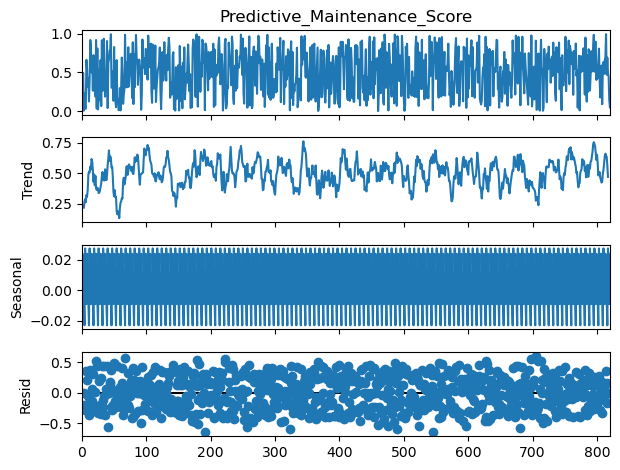

Check the seasonal component for repeating patterns in Predictive_Maintenance_Score.


In [15]:
# Define the seasonality analysis function
def seasonality_analysis(series, column_name='Predictive_Maintenance_Score', period=12):
    decomposition = seasonal_decompose(series[column_name], model='additive', period=period)
    fig = decomposition.plot()
    plt.show()
    print(f'Check the seasonal component for repeating patterns in {column_name}.')

print("\n=== Seasonality Analysis ===")
seasonality_analysis(df_new, 'Predictive_Maintenance_Score', period=7)  # Adjust period as needed


=== Autocorrelation Analysis (ACF/PACF) ===


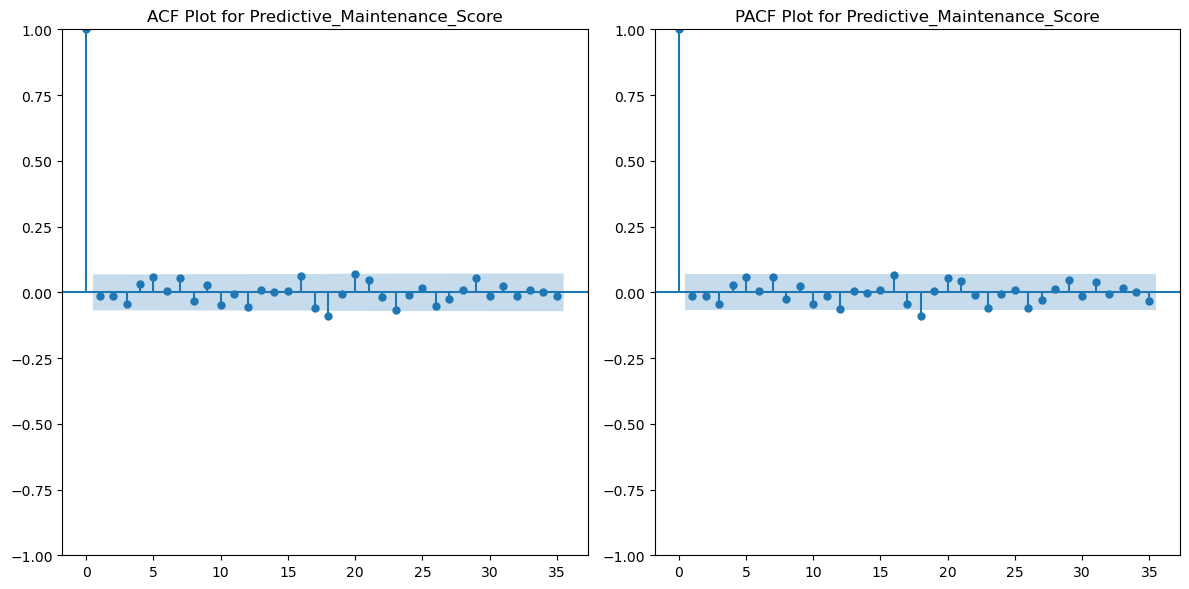

Use ACF/PACF to determine AR (p) and MA (q) orders for Predictive_Maintenance_Score.


' ACF & PACF dying quickly (within confidence bands) indicates the time series is stationary or near stationary.\n\t•\tNo significant autocorrelations → no strong AR (p) or MA (q) components. '

In [17]:

# Define the autocorrelation analysis function
def autocorrelation_analysis(series, column_name='Predictive_Maintenance_Score', lags=20):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series[column_name], lags=35, ax=plt.gca())
    plt.title(f'ACF Plot for {column_name}')
    plt.subplot(122)
    plot_pacf(series[column_name], lags=35, ax=plt.gca())
    plt.title(f'PACF Plot for {column_name}')
    plt.tight_layout()
    plt.show()
    print(f'Use ACF/PACF to determine AR (p) and MA (q) orders for {column_name}.')
    
print("\n=== Autocorrelation Analysis (ACF/PACF) ===")
autocorrelation_analysis(df_new, 'Predictive_Maintenance_Score', lags=20)

''' ACF & PACF dying quickly (within confidence bands) indicates the time series is stationary or near stationary.
	•	No significant autocorrelations → no strong AR (p) or MA (q) components. '''



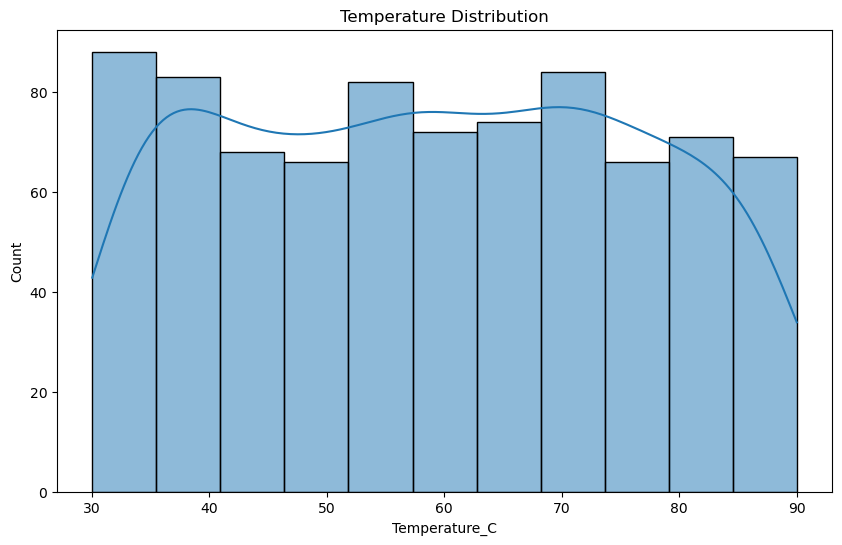

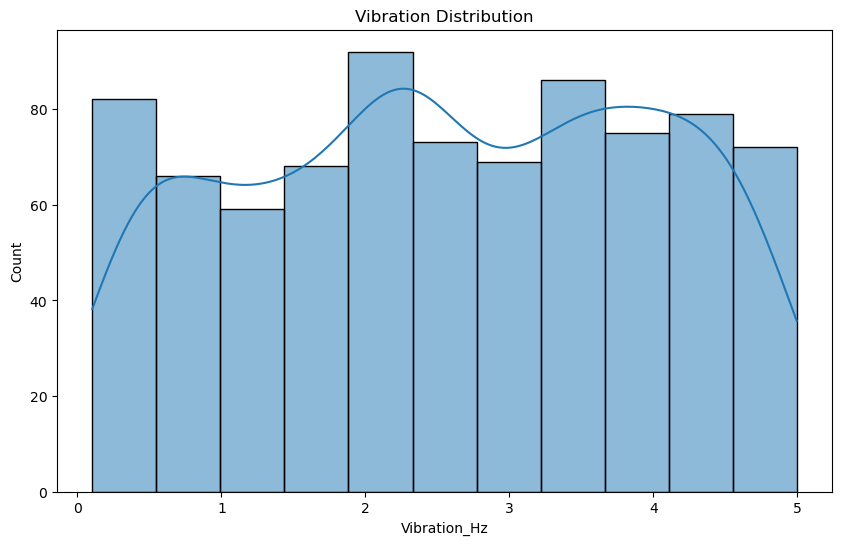

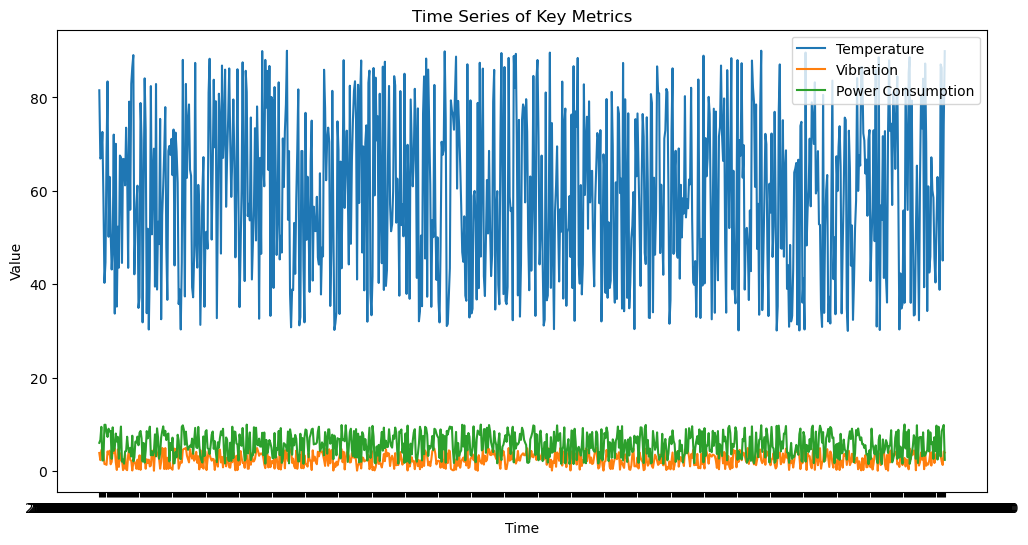

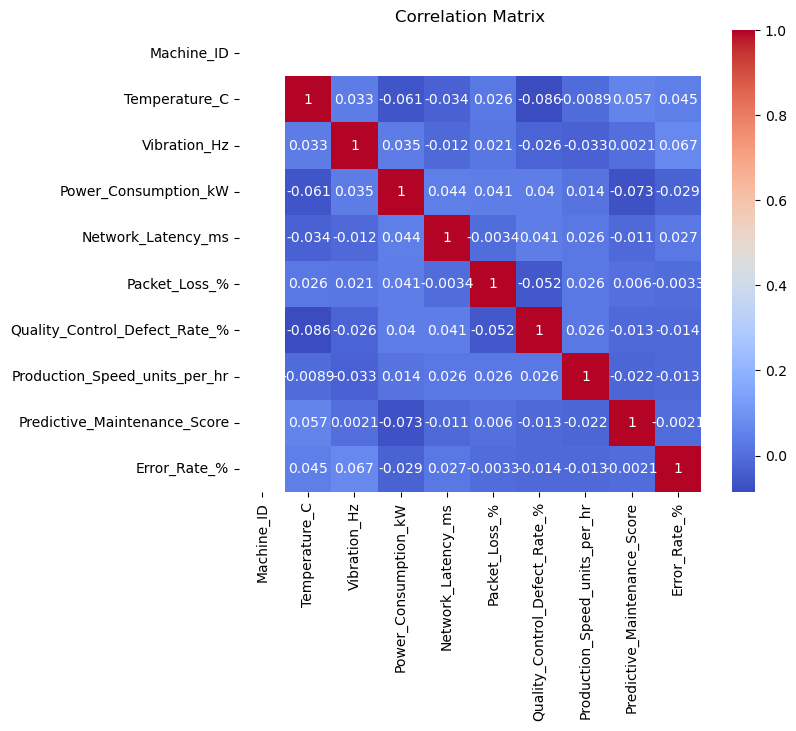

In [19]:


# Distribution Plots
plt.figure(figsize=(10,6))
sns.histplot(df_new['Temperature_C'], kde=True)
plt.title('Temperature Distribution')
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df_new['Vibration_Hz'], kde=True)
plt.title('Vibration Distribution')
plt.show()

# Time Series Plots
plt.figure(figsize=(12,6))
plt.plot(df_new['Timestamp'], df_new['Temperature_C'], label='Temperature')
plt.plot(df_new['Timestamp'], df_new['Vibration_Hz'], label='Vibration')
plt.plot(df_new['Timestamp'],df_new['Power_Consumption_kW'], label='Power Consumption')
plt.legend()
plt.title('Time Series of Key Metrics')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Correlation Matrix
corr_matrix = df_new[['Machine_ID', 'Temperature_C', 'Vibration_Hz', 'Power_Consumption_kW', 'Network_Latency_ms', 'Packet_Loss_%', 'Quality_Control_Defect_Rate_%', 'Production_Speed_units_per_hr', 'Predictive_Maintenance_Score', 'Error_Rate_%']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('manufacturing_6G_dataset.csv')

# Ensure 'Timestamp' is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filter for a specific machine (e.g., Machine_ID = 39)
machine_id = 39
machine_data = df[df['Machine_ID'] == machine_id]

# Set 'Timestamp' as the index for time series analysis
machine_data.set_index('Timestamp', inplace=True)

# Sort by time to ensure chronological order
machine_data.sort_index(inplace=True)


In [23]:
# Create lag features for key variables
lag_features = ['Temperature_C', 'Vibration_Hz', 'Power_Consumption_kW', 'Error_Rate_%']
for feature in lag_features:
    machine_data[f'{feature}_lag1'] = machine_data[feature].shift(1)

# Create rolling statistics (moving average and standard deviation)
rolling_window = 5
for feature in lag_features:
    machine_data[f'{feature}_rolling_mean'] = machine_data[feature].rolling(window=rolling_window).mean()
    machine_data[f'{feature}_rolling_std'] = machine_data[feature].rolling(window=rolling_window).std()

# Drop rows with NaN values created by lagging and rolling operations
machine_data.dropna(inplace=True)

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
scaled_columns = ['Temperature_C', 'Vibration_Hz', 'Power_Consumption_kW', 'Error_Rate_%', 
                  'Temperature_C_lag1', 'Vibration_Hz_lag1', 'Power_Consumption_kW_lag1', 
                  'Error_Rate_%_lag1']
machine_data[scaled_columns] = scaler.fit_transform(machine_data[scaled_columns])


/var/folders/8n/gqxztd6n19n52d_zyn3b1z_r0000gn/T/ipykernel_35559/1507443857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_data[f'{feature}_lag1'] = machine_data[feature].shift(1)
/var/folders/8n/gqxztd6n19n52d_zyn3b1z_r0000gn/T/ipykernel_35559/1507443857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_data[f'{feature}_lag1'] = machine_data[feature].shift(1)
/var/folders/8n/gqxztd6n19n52d_zyn3b1z_r0000gn/T/ipykernel_35559/1507443857.py:4: SettingWithCopyWarning: 
A value is trying t

In [25]:
# Define features (X) and target (y)
X = machine_data.drop(columns=['Predictive_Maintenance_Score'])
y = machine_data['Predictive_Maintenance_Score']

# Split data into training (80%) and testing (20%) sets based on time
train_size = int(len(machine_data) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50027D-01    |proj g|=  8.12854D-01


 This problem is unconstrained.



At iterate    5    f=  3.41707D-01    |proj g|=  1.05700D-01

At iterate   10    f=  2.34839D-01    |proj g|=  1.76758D-01

At iterate   15    f=  2.14989D-01    |proj g|=  3.37248D-02

At iterate   20    f=  2.11981D-01    |proj g|=  1.32299D-02

At iterate   25    f=  2.11804D-01    |proj g|=  1.37940D-02

At iterate   30    f=  2.11793D-01    |proj g|=  1.94518D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     42      1     0     0   5.378D-05   2.118D-01
  F =  0.21179262947306718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


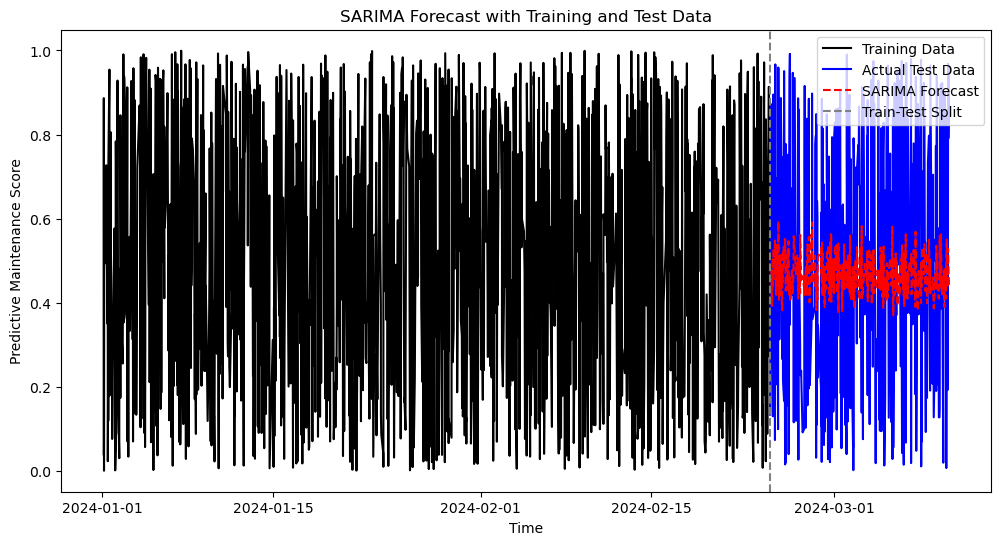

📌 SARIMA Model Performance:
✅ MSE: 0.0888
✅ RMSE: 0.2980
✅ MAE: 0.2601


In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define exogenous variables (lag features)
exog_train = X_train[['Temperature_C', 'Vibration_Hz', 'Power_Consumption_kW', 'Error_Rate_%']]
exog_test = X_test[['Temperature_C', 'Vibration_Hz', 'Power_Consumption_kW', 'Error_Rate_%']]

# Fit SARIMA Model
sarima_model = SARIMAX(y_train, exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_fitted = sarima_model.fit()

# Forecast for test period
sarima_forecast = sarima_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=exog_test)

# 📊 Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label="Training Data", color='black')
plt.plot(y_test.index, y_test, label="Actual Test Data", color='blue')
plt.plot(y_test.index, sarima_forecast, label="SARIMA Forecast", linestyle="dashed", color='red')

# Formatting
plt.axvline(y_train.index[-1], color='gray', linestyle='--', label="Train-Test Split")
plt.legend()
plt.title("SARIMA Forecast with Training and Test Data")
plt.xlabel("Time")
plt.ylabel("Predictive Maintenance Score")
plt.show()

# 📉 Performance Evaluation
mse = mean_squared_error(y_test, sarima_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, sarima_forecast)

print(f"📌 SARIMA Model Performance:")
print(f"✅ MSE: {mse:.4f}")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE: {mae:.4f}")

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Performance Metrics for SARIMA
mse_sarima = mean_squared_error(y_test, sarima_forecast)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima = mean_absolute_error(y_test, sarima_forecast)
r2_sarima = r2_score(y_test, sarima_forecast)

print(f"📌 SARIMA Model Performance:")
print(f"✅ MSE: {mse_sarima:.4f}")
print(f"✅ RMSE: {rmse_sarima:.4f}")
print(f"✅ MAE: {mae_sarima:.4f}")
print(f"✅ R² Score: {r2_sarima:.4f}")


📌 SARIMA Model Performance:
✅ MSE: 0.0888
✅ RMSE: 0.2980
✅ MAE: 0.2601
✅ R² Score: -0.0514


2025-03-25 11:34:22.796445: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-25 11:34:22.796565: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-25 11:34:22.796572: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-03-25 11:34:22.796606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-25 11:34:22.796616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, 

Epoch 1/50


2025-03-25 11:34:23.432727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.2566
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0283
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0105
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0062
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0054
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0050
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0044
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0040
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0036
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0032
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0030
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 

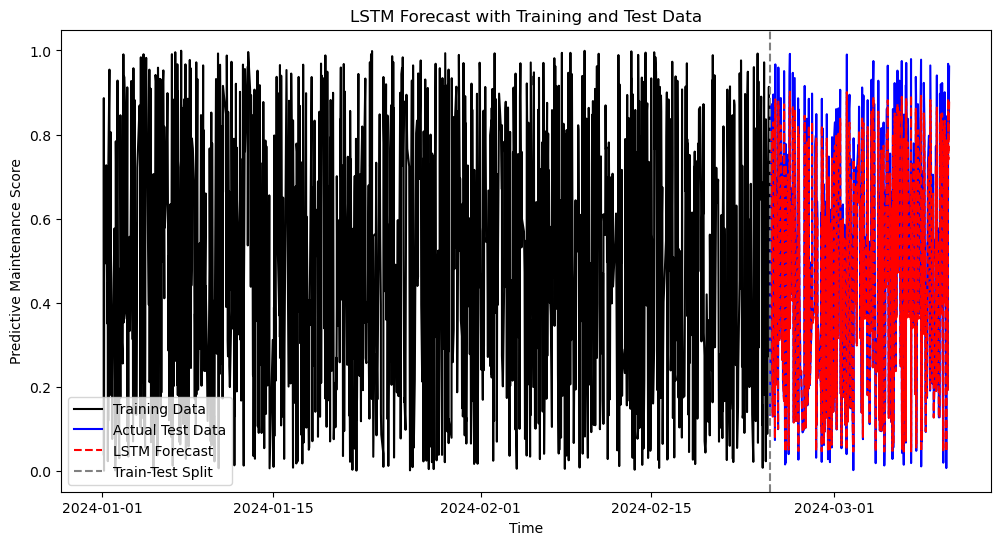

📌 LSTM Model Performance:
✅ MSE: 0.0014
✅ RMSE: 0.0377
✅ MAE: 0.0281


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = np.reshape(y_train.values, (y_train.shape[0], 1, 1))
X_test_lstm = np.reshape(y_test.values, (y_test.shape[0], 1, 1))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train_lstm, y_train.values, epochs=50, batch_size=16, verbose=1)

# Forecast
y_pred_lstm = model.predict(X_test_lstm)

# 📊 Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label="Training Data", color='black')
plt.plot(y_test.index, y_test, label="Actual Test Data", color='blue')
plt.plot(y_test.index, y_pred_lstm, label="LSTM Forecast", linestyle="dashed", color='red')
plt.axvline(y_train.index[-1], color='gray', linestyle='--', label="Train-Test Split")
plt.legend()
plt.title("LSTM Forecast with Training and Test Data")
plt.xlabel("Time")
plt.ylabel("Predictive Maintenance Score")
plt.show()

# 📉 Performance Evaluation
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f"📌 LSTM Model Performance:")
print(f"✅ MSE: {mse_lstm:.4f}")
print(f"✅ RMSE: {rmse_lstm:.4f}")
print(f"✅ MAE: {mae_lstm:.4f}")

In [55]:
from sklearn.metrics import r2_score

# Calculate Performance Metrics for LSTM
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"📌 LSTM Model Performance:")
print(f"✅ MSE: {mse_lstm:.4f}")
print(f"✅ RMSE: {rmse_lstm:.4f}")
print(f"✅ MAE: {mae_lstm:.4f}")
print(f"✅ R² Score: {r2_lstm:.4f}")

📌 LSTM Model Performance:
✅ MSE: 0.0014
✅ RMSE: 0.0377
✅ MAE: 0.0281
✅ R² Score: 0.9832


11:42:15 - cmdstanpy - INFO - Chain [1] start processing
11:42:15 - cmdstanpy - INFO - Chain [1] done processing


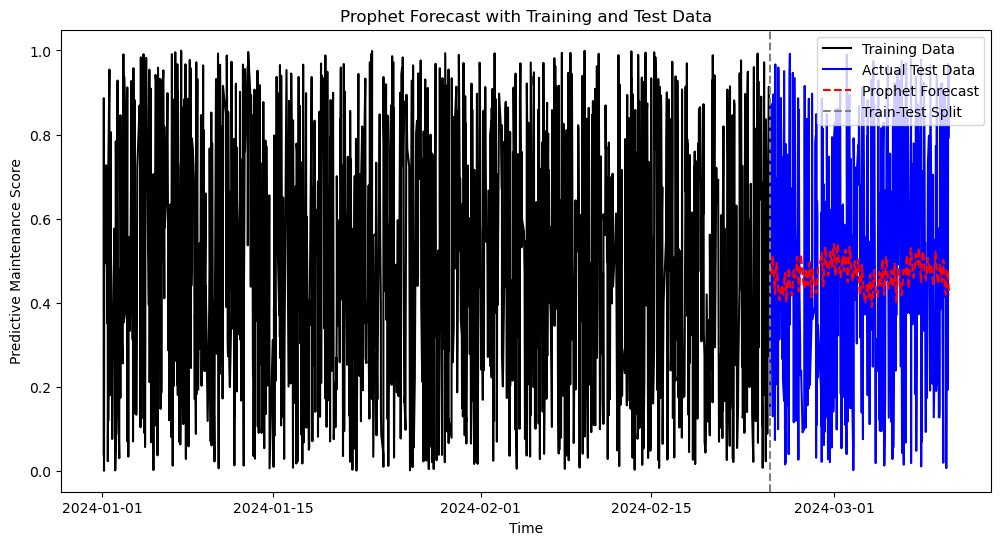

📌 Prophet Model Performance:
✅ MSE: 0.0876
✅ RMSE: 0.2960
✅ MAE: 0.2567


In [43]:
from prophet import Prophet
import pandas as pd

# Prepare Data for Prophet
prophet_df = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})
prophet_test_df = pd.DataFrame({'ds': y_test.index, 'y': y_test.values})

# Fit Prophet Model
model = Prophet()
model.fit(prophet_df)

# Forecast
future = pd.DataFrame({'ds': y_test.index})
forecast = model.predict(future)

# 📊 Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label="Training Data", color='black')
plt.plot(y_test.index, y_test, label="Actual Test Data", color='blue')
plt.plot(y_test.index, forecast['yhat'], label="Prophet Forecast", linestyle="dashed", color='red')
plt.axvline(y_train.index[-1], color='gray', linestyle='--', label="Train-Test Split")
plt.legend()
plt.title("Prophet Forecast with Training and Test Data")
plt.xlabel("Time")
plt.ylabel("Predictive Maintenance Score")
plt.show()

# 📉 Performance Evaluation
mse_prophet = mean_squared_error(y_test, forecast['yhat'])
rmse_prophet = np.sqrt(mse_prophet)
mae_prophet = mean_absolute_error(y_test, forecast['yhat'])

print(f"📌 Prophet Model Performance:")
print(f"✅ MSE: {mse_prophet:.4f}")
print(f"✅ RMSE: {rmse_prophet:.4f}")
print(f"✅ MAE: {mae_prophet:.4f}")

In [57]:
# Calculate Performance Metrics for Prophet
mse_prophet = mean_squared_error(y_test, forecast['yhat'])
rmse_prophet = np.sqrt(mse_prophet)
mae_prophet = mean_absolute_error(y_test, forecast['yhat'])
r2_prophet = r2_score(y_test, forecast['yhat'])

print(f"📌 Prophet Model Performance:")
print(f"✅ MSE: {mse_prophet:.4f}")
print(f"✅ RMSE: {rmse_prophet:.4f}")
print(f"✅ MAE: {mae_prophet:.4f}")
print(f"✅ R² Score: {r2_prophet:.4f}")

📌 Prophet Model Performance:
✅ MSE: 0.0876
✅ RMSE: 0.2960
✅ MAE: 0.2567
✅ R² Score: -0.0370


 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=586.213, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=588.038, Time=0.82 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : AIC=586.511, Time=54.30 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=588.054, Time=1.53 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=3.57 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=62.91 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=586.723, Time=44.03 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=54.64 sec
 ARIMA(0,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=89.26 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=588.207, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=590.029, Time=1.07 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=588.503, Time=47.24 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=590.046, Time=4.54 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=6.32 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=inf, Time=71.43 sec
 ARIMA(0,0,1)(2,0,0)[24] in

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


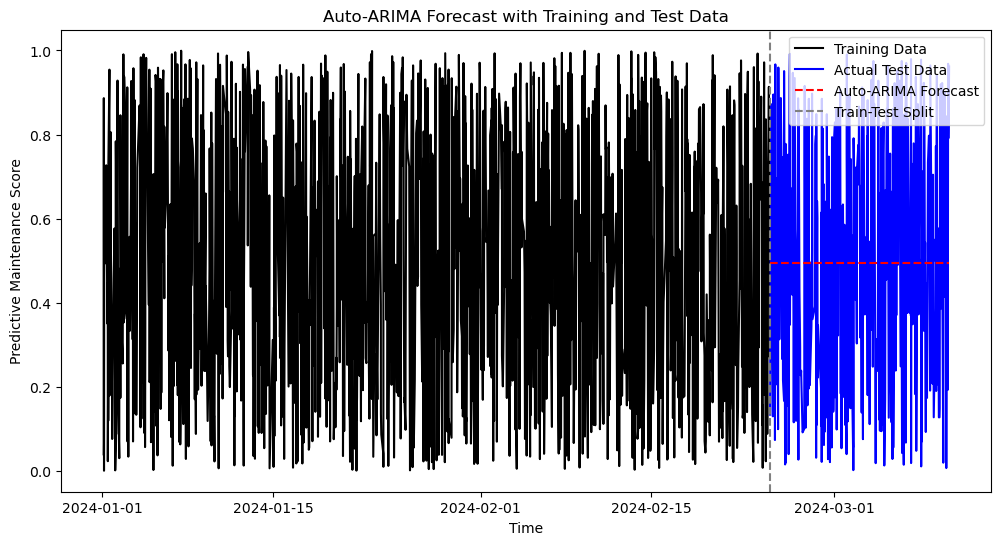

📌 Auto-ARIMA Model Performance:
✅ MSE: 0.0845
✅ RMSE: 0.2906
✅ MAE: 0.2532


In [70]:
from pmdarima import auto_arima

# Fit Auto-ARIMA Model
autoarima_model = auto_arima(
    y_train,
    exogenous=X_train[['Temperature_C', 'Vibration_Hz', 'Power_Consumption_kW', 'Error_Rate_%']],
    d=0,  # Try different values (0,1,2)
    seasonal=True,
    m=24,
    stepwise=False,  # Turn off stepwise to allow better search
    suppress_warnings=True,
    trace=True
)
print(autoarima_model.summary())

# Forecast
y_pred_arima = autoarima_model.predict(n_periods=len(y_test))

# 📊 Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label="Training Data", color='black')
plt.plot(y_test.index, y_test, label="Actual Test Data", color='blue')
plt.plot(y_test.index, y_pred_arima, label="Auto-ARIMA Forecast", linestyle="dashed", color='red')
plt.axvline(y_train.index[-1], color='gray', linestyle='--', label="Train-Test Split")
plt.legend()
plt.title("Auto-ARIMA Forecast with Training and Test Data")
plt.xlabel("Time")
plt.ylabel("Predictive Maintenance Score")
plt.show()

# 📉 Performance Evaluation
mse_arima = mean_squared_error(y_test, y_pred_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(y_test, y_pred_arima)

print(f"📌 Auto-ARIMA Model Performance:")
print(f"✅ MSE: {mse_arima:.4f}")
print(f"✅ RMSE: {rmse_arima:.4f}")
print(f"✅ MAE: {mae_arima:.4f}")

In [72]:
# Calculate Performance Metrics for Auto-ARIMA
mse_arima = mean_squared_error(y_test, y_pred_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(y_test, y_pred_arima)
r2_arima = r2_score(y_test, y_pred_arima)

print(f"📌 Auto-ARIMA Model Performance:")
print(f"✅ MSE: {mse_arima:.4f}")
print(f"✅ RMSE: {rmse_arima:.4f}")
print(f"✅ MAE: {mae_arima:.4f}")
print(f"✅ R² Score: {r2_arima:.4f}")

📌 Auto-ARIMA Model Performance:
✅ MSE: 0.0845
✅ RMSE: 0.2906
✅ MAE: 0.2532
✅ R² Score: -0.0001


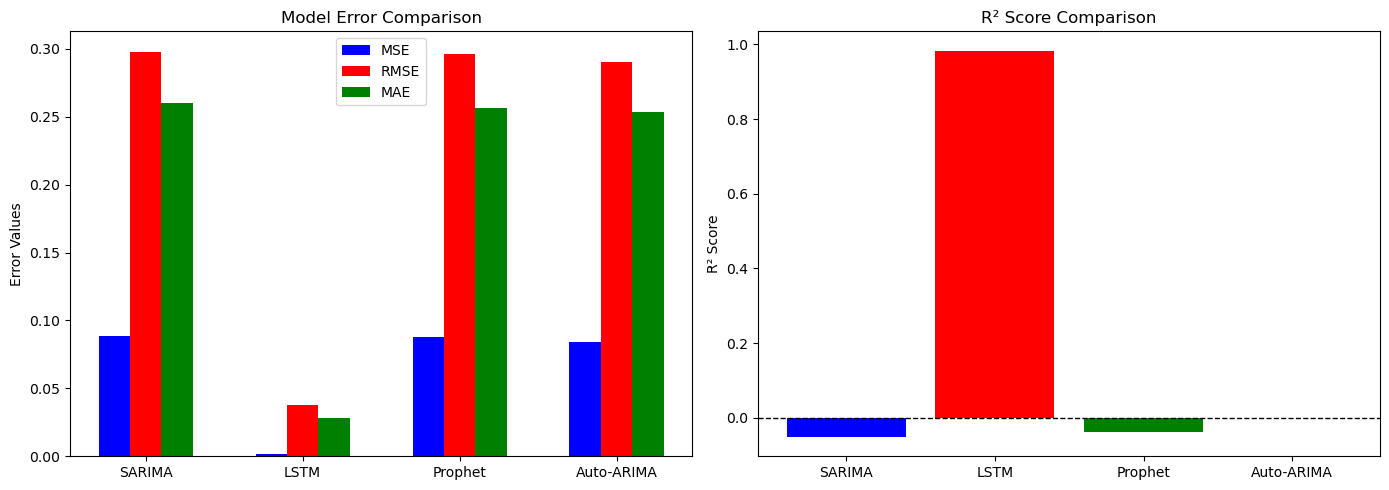

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Model Names
models = ["SARIMA", "LSTM", "Prophet", "Auto-ARIMA"]

# Performance Metrics
mse_values = [0.0888, 0.0014, 0.0876, 0.0845]
rmse_values = [0.2980, 0.0377, 0.2960, 0.2906]
mae_values = [0.2601, 0.0281, 0.2567, 0.2532]
r2_values = [-0.0514, 0.9832, -0.0370, -0.0001]

# Create Subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 📊 Bar Chart for Performance Metrics
x = np.arange(len(models))
width = 0.2

ax[0].bar(x - width, mse_values, width, label="MSE", color='blue')
ax[0].bar(x, rmse_values, width, label="RMSE", color='red')
ax[0].bar(x + width, mae_values, width, label="MAE", color='green')
ax[0].set_xticks(x)
ax[0].set_xticklabels(models)
ax[0].set_ylabel("Error Values")
ax[0].set_title("Model Error Comparison")
ax[0].legend()

# 📈 Line Plot for R² Scores
ax[1].bar(models, r2_values, color=['blue', 'red', 'green', 'purple'])
ax[1].axhline(0, color='black', linestyle="--", linewidth=1)  # Reference line at 0
ax[1].set_ylabel("R² Score")
ax[1].set_title("R² Score Comparison")

plt.tight_layout()
plt.show()

	•	LSTM has the lowest RMSE (0.0377), MSE (0.0014), and MAE (0.0281), and the highest R² (0.9832).
🔹 This means LSTM captures patterns very well and generalizes best for predictive maintenance.
	•	SARIMA, Prophet, and Auto-ARIMA have high RMSE (~0.29) and negative R² values, meaning they perform poorly.
	•	Auto-ARIMA performed slightly better than SARIMA & Prophet, but still poorly overall.

Conclusion: Best Model

✅ LSTM is the best model for forecasting the Predictive Maintenance Score due to its high accuracy and low error.
❌ SARIMA, Prophet, and Auto-ARIMA are not ideal as they fail to capture the machine’s complex time series patterns.

✅ 0 - 0.5 → No Maintenance Needed
	•	Machine is operating efficiently.
	•	No immediate action required.

⚠️ 0.5 - 0.7 → Maintenance Recommended
	•	Machine shows early signs of inefficiency.
	•	Preventive maintenance should be scheduled to avoid failures.

❌ 0.7+ → Machine Inefficient / Replacement Needed
	•	High probability of failure or critical inefficiency.
	•	Maintenance or possible replacement required.